In [1]:
import torch
import torch.nn as nn
# from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.efficientnet import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.nn.functional as F

from PIL import Image
import os

In [2]:
weights = EfficientNet_V2_S_Weights.DEFAULT
transforms = weights.transforms()
eff_net = efficientnet_v2_s(weights=weights)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from IPython.display import clear_output
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(DEVICE)

clear_output()

In [5]:
class VisionEncoder(nn.Module):
  def __init__(self, hidden_dim, output_dim, freeze_backbone=False):
    super(VisionEncoder, self).__init__()
    self.model = eff_net
    #freeze model weights
    if freeze_backbone:
      for param in self.model.parameters():
        param.requires_grad = False

    self.model.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=output_dim)
    )

  def forward(self, x):
    return self.model(x)

In [6]:

class TextEncoder(nn.Module):
  def __init__(self, hidden_dim, output_dim, freeze_backbone=False):
    super(TextEncoder, self).__init__()
    self.model = text_model
    # freeze model weights
    if freeze_backbone:
      for param in self.model.parameters():
        param.requires_grad = False
    self.fc = nn.Sequential(
        nn.Linear(in_features=768, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=output_dim)
    )

  def forward(self, x):
    input_ids, attention_mask = x
    x = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    return self.fc(x)

In [8]:
class MiniCLIP(nn.Module):
  def __init__(self, vision_encoder, text_encoder):
    super(MiniCLIP, self).__init__()
    self.vision_encoder = vision_encoder
    self.text_encoder = text_encoder

    self.temperature = nn.Parameter(torch.tensor(1.0))

  def get_similarity(self, image_features, text_features):
    return (image_features @ text_features.T) * torch.exp(self.temperature)

  def get_image_features(self, image):
    return self.vision_encoder(image)

  def get_text_features(self, text):
    return self.text_encoder(text)

  def forward(self, image, text):
    image_features = F.normalize(self.get_image_features(image))
    text_features = F.normalize(self.get_text_features(text))
    similarities = self.get_similarity(image_features, text_features)
    return similarities

In [8]:
class SymmetricLoss(nn.Module):
  def __init__(self):
    super(SymmetricLoss, self).__init__()
    self.criterion_image = nn.CrossEntropyLoss()
    self.criterion_text = nn.CrossEntropyLoss()

  def forward(self, logits):
    labels = torch.arange(logits.size(0)).to(DEVICE)
    loss_i = self.criterion_image(logits, labels)
    loss_t = self.criterion_text(logits.T, labels)
    sym_loss = (loss_i + loss_t) / 2
    return sym_loss

In [20]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_HIDDEN_DIM = 512
IMAGE_OUTPUT_DIM = 256
TEXT_HIDDEN_DIM = 512
TEXT_OUTPUT_DIM = 256


vision_encoder = VisionEncoder(IMAGE_HIDDEN_DIM, IMAGE_OUTPUT_DIM).to(DEVICE)
text_encoder = TextEncoder(TEXT_HIDDEN_DIM, TEXT_OUTPUT_DIM).to(DEVICE)
miniclip = MiniCLIP(vision_encoder, text_encoder).to(DEVICE)


vision_encoder.load_state_dict(torch.load("models/vision_state_dictv2.pt"))
text_encoder.load_state_dict(torch.load("models/text_state_dictv2.pt"))
miniclip.load_state_dict(torch.load("models/best_modelv2.pt"))

<All keys matched successfully>

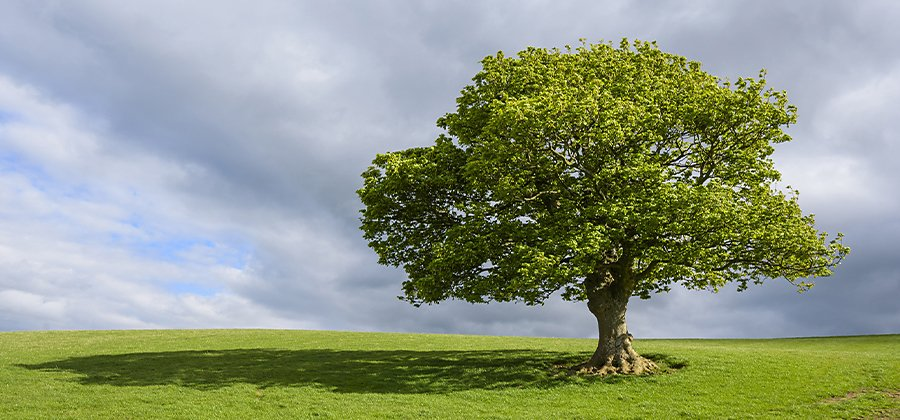

In [21]:
import requests
from PIL import Image
url = 'https://cc-prod.scene7.com/is/image/CCProdAuthor/draw-trees_P1_900x420?$pjpeg$&jpegSize=200&wid=900'
img = Image.open(requests.get(url, stream=True).raw)
img

In [51]:
transformed_img = transforms(img)
sample_texts = ["a car on a road", "a man eating mango", "a tree and grass", "a dog running"]
tokens = tokenizer(sample_texts, return_tensors="pt", truncation=True, padding="max_length")

In [52]:
miniclip.eval()
preds = F.softmax(miniclip(transformed_img.unsqueeze(0).to(DEVICE), (tokens.input_ids.to(DEVICE), tokens.attention_mask.to(DEVICE))), dim=-1)
print((preds*100).tolist())
sample_texts[preds.argmax(dim=-1)]

[[0.05779107287526131, 0.2435838133096695, 94.36991882324219, 5.328710556030273]]


'a tree and grass'

In [53]:
from typing import List
def find_similarity(model, image, texts: List[str]):
  model.eval()
  with torch.inference_mode():
    transformed_img = transforms(image)
    tokens = tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length")
    logits = miniclip(transformed_img.unsqueeze(0).to(DEVICE), (tokens.input_ids.to(DEVICE), tokens.attention_mask.to(DEVICE)))
    pred_probs = F.softmax(logits, dim=-1)
    pred_idx = pred_probs.argmax(dim=-1)

    return {"prediction_probabilities": (pred_probs.squeeze()*100).detach().cpu().tolist(),
            "predicted_label": pred_idx,
            "label": texts[pred_idx]}

In [54]:
output = find_similarity(miniclip, img, sample_texts)
output

{'prediction_probabilities': [0.05779107287526131,
  0.2435838133096695,
  94.36991882324219,
  5.328710556030273],
 'predicted_label': tensor([2], device='cuda:0'),
 'label': 'a tree and grass'}

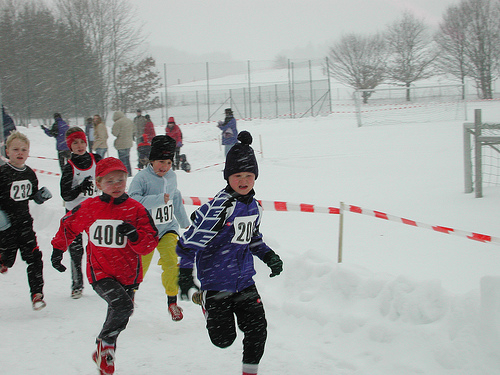

In [55]:
random_img = "data/Flicker8k_Dataset/72218201_e0e9c7d65b.jpg"
random_img = Image.open(random_img)
random_img

In [56]:
sample_texts = ["a photo of elephants", "a photo of children running near a river", "a photo of children running in snow"]
find_similarity(miniclip, random_img, sample_texts)

{'prediction_probabilities': [1.2650662660598755,
  0.07399718463420868,
  98.66092681884766],
 'predicted_label': tensor([2], device='cuda:0'),
 'label': 'a photo of children running in snow'}

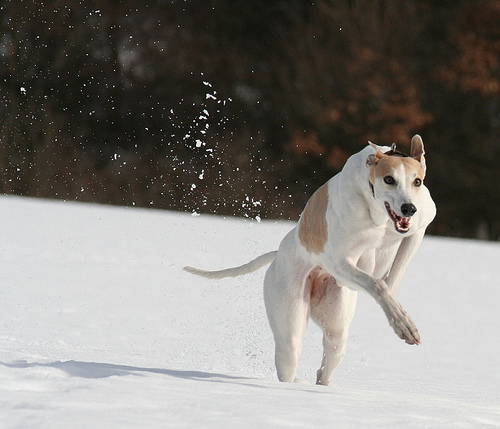

In [57]:
random_img_2 = "data/Flicker8k_Dataset/101654506_8eb26cfb60.jpg"
random_img_2 = Image.open(random_img_2)
random_img_2

In [58]:
sample_texts = ["a cat running in the snow", "a dog running in summer", "a dog running in the snow", "a group of girls playing in the snow"]
find_similarity(miniclip, random_img_2, sample_texts)

{'prediction_probabilities': [43.89445495605469,
  6.943025588989258,
  48.54465866088867,
  0.6178674101829529],
 'predicted_label': tensor([2], device='cuda:0'),
 'label': 'a dog running in the snow'}